In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
from tqdm import tqdm
import numpy as np
from PIL import Image
import os
import pickle
import json
import cv2
import re
import keras

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [3]:
# make image dataloader using flow_from_dataframe
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator

# load data to extract labels
data_dir = 'mmhs150k/'
model_dir = 'models/'
tweet_dict = json.load(open(data_dir + 'MMHS150K_GT.json', 'r'))

In [4]:
# load pretrained LSTM and CNN for text and images
from keras.models import load_model

lstm = load_model(model_dir + 'lstm.h5')
cnn = load_model(model_dir + 'CNN.h5')

print(lstm.summary())
print(cnn.summary())

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           7565100   
_________________________________________________________________
lstm_3 (LSTM)                (None, 150)               150600    
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 151       
Total params: 7,715,851
Trainable params: 150,751
Non-trainable params: 7,565,100
_________________________________________________________________
None
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
___________

In [5]:
# create new models that are all but the last layer
from keras.models import Sequential, Model

text_net = Sequential()
for layer in lstm.layers[:-1]: text_net.add(layer)
print(text_net.summary())

img_net = Sequential()
for layer in cnn.layers[:-3]: img_net.add(layer)
print(img_net.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 50, 100)           7565100   
_________________________________________________________________
lstm_3 (LSTM)                (None, 150)               150600    
Total params: 7,715,700
Trainable params: 150,600
Non-trainable params: 7,565,100
_________________________________________________________________
None
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten_1 (Flatten)          (None, 131072)            0         
Total params: 21,802,784
Trainable params: 0
Non-trainable params: 21,802,784
_________________________________________________________________

In [6]:
# build full FCM model using concatenation layer
from keras.layers.merge import concatenate
from keras.layers import Dense, Input
from keras.optimizers import Adam

text_input = Input((text_net.layers[0].input_shape[-1],)) # get rid of None's in front
img_text_input = Input((text_net.layers[0].input_shape[-1],))
img_input = Input((img_net.layers[0].input_shape[1:])) # get rid of None in front

text_embed = text_net(text_input)
img_text_embed = text_net(img_text_input)
img_embed = img_net(img_input)

x = concatenate([text_embed, img_text_embed, img_embed])
# x = Dense(2048 + 150 + 150, activation='relu')(x)
# x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
prediction = Dense(1, activation='sigmoid')(x)

fcm_model = Model(inputs=[text_input, img_text_input, img_input], outputs=prediction)
print(fcm_model.summary())

optimizer = Adam(lr = 0.001)
fcm_model.compile(loss="binary_crossentropy", optimizer=optimizer, metrics=['accuracy'])

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 50)           0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 150)          7715700     input_1[0][0]                    
                                                                 input_2[0][0]              

In [7]:
# produce text generators

# method for cleaning text like in https://nlp.stanford.edu/projects/glove/preprocess-twitter.rb
def hashtag(text):
    hashtag_body = text.group()[1:]
    if hashtag_body.isupper(): return "<hashtag> {} ".format(hashtag_body.lower())
    else: return ' '.join(["<hashtag>"] + [re.sub(r"([A-Z])",r" \1", hashtag_body, flags=re.MULTILINE | re.DOTALL)])

def allcaps(text): return text.group().lower() + ' <allcaps> '    

def clean_tweet_text(t):
    eyes = r'[8:=;]'
    nose = r"['`\-]?"
    
    t = re.sub(r'https?:\/\/\S+\b|www\.(\w+\.)+\S*', '<url>', t)
    t = re.sub(r'@\w+', '<user>', t)
    t = re.sub(r'{}{}[)dD]+|[)dD]+{}{}'.format(eyes, nose, nose, eyes), '<smile>', t)
    t = re.sub(r'{}{}p+".format(eyes, nose)', '<lolface>', t)
    t = re.sub(r'{}{}\(+|\)+{}{}'.format(eyes, nose, nose, eyes), '<sadface>', t)
    t = re.sub(r'{}{}[\/|l*]'.format(eyes, nose), '<neutralface>', t)
    t = re.sub(r'/', ' / ', t)
    t = re.sub(r'<3','<heart>', t)
    t = re.sub(r'[-+]?[.\d]*[\d]+[:,.\d]*', '<number>', t)
    t = re.sub(r'#\S+', hashtag, t)
    t = re.sub(r'([!?.]){2,}', r'\1 <repeat>', t)
    t = re.sub(r'\b(\S*?)(.)\2{2,}\b', r'\1\2 <elong>', t)
    t = re.sub(r'([A-Z]){2,}', allcaps, t)
    t = re.sub(r'{}'.format(r'[\".,-;&:]'), ' ', t)
    return t.lower()

In [8]:
# produce text in proper form
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

def get_text_data(path, tokenizer, pad_len):
    data = []
    for id in open(data_dir + path, 'r').read().splitlines():

        # process text (tweet special tokens)
        text = tweet_dict[id]['tweet_text']
        text = clean_tweet_text(text)

        # get majority vote label
        binary_labels = [1 if n > 0 else 0 for n in tweet_dict[id]['labels']]
        label = 1 if sum(binary_labels)/len(tweet_dict[id]['labels']) > 0.5 else 0

        # save to list
        data.append((text, label))
    
    # change to numbers using tokenizer and pad
    texts, labels = zip(*data)
    sequences = tokenizer.texts_to_sequences(texts) # apply train tokenizer
    x = pad_sequences(sequences, maxlen=pad_len)
    y = np.asarray(labels)

    return (x, y)

tokenizer = pickle.load(open(model_dir + 'tokenizer.pkl', 'rb'))
pad_len = text_net.layers[0].input_shape[-1]

train_x, train_y = get_text_data('splits/train_ids.txt', tokenizer, pad_len)


# train_data = get_data_list('splits/train_ids.txt')

In [9]:
# produce img generators
from keras.preprocessing.text import Tokenizer
import pickle

# get img generator from path
def get_img_gen(path):
    
    # build dictionary mapping id's to labels
    data = {'id': [], 'label': []}
    for id in open(data_dir + path, 'r').read().splitlines():

        # get majority vote label
        binary_labels = [1 if n > 0 else 0 for n in tweet_dict[id]['labels']]
        label = 1 if sum(binary_labels)/len(tweet_dict[id]['labels']) > 0.5 else 0

        # save to data dict
        data['id'].append(id + '.jpg')
        data['label'].append(str(label))
        
    data_df = pd.DataFrame.from_dict(data) # get dataframe to flow from
    
    datagen = ImageDataGenerator(rescale=1./255,
                                 samplewise_center=True,
                                 samplewise_std_normalization=True,
                                 width_shift_range=0.3,
                                 height_shift_range=0.3,
                                 shear_range=10,
                                 horizontal_flip=True,
                                 vertical_flip=True)
    datagen = ImageDataGenerator(rescale=1./255)
    generator = datagen.flow_from_dataframe(
        dataframe=data_df,
        directory=data_dir + 'img_resized',
        x_col='id',
        y_col='label',
        shuffle = False, # preserve order
        target_size=(299, 299),
        batch_size=16,
        class_mode='binary')
    
    return generator

img_generator = get_img_gen('splits/train_ids.txt')


Found 134823 validated image filenames belonging to 2 classes.


In [42]:
# build multimodal dataloader
def multimodal_generator(img_gen, text_x, text_y, img_text_x, img_text_y):
    batch_size = img_gen.batch_size
    
    i = 0
    while True:
        img = img_gen.next()
        text = text_x[i:min(i + batch_size, len(text_x))]
        img_text = img_text_x[i:min(i + batch_size, len(text_x))]
        
        if not (np.array_equal(text_y[i:i + batch_size], img_text_y[i:i + batch_size]) and 
               np.array_equal(text_y[i:i + batch_size], img[1])):
            print(text_y[i:i + batch_size], img_text_y[i:i + batch_size], img[1])
        assert(np.array_equal(text_y[i:i + batch_size], img_text_y[i:i + batch_size]) and 
               np.array_equal(text_y[i:i + batch_size], img[1])) # make sure that the order is preserved
        
        yield [text, img_text, img[0]], img[1]
        i += batch_size
        
train_generator = multimodal_generator(img_generator, train_x, train_y, train_x, train_y)

In [33]:
# x, y = next(train_generator)

num_samples = len(img_generator.classes)
batch_size = img_generator.batch_size

# train model
history = fcm_model.fit_generator(train_generator, 
                    shuffle=True,
                    epochs=1,
                    steps_per_epoch=num_samples//batch_size)

Epoch 1/1
8050/8426 [===========================>..] - ETA: 2:51 - loss: 0.0447 - accuracy: 0.9997

ValueError: All input arrays (x) should have the same number of samples. Got array shapes: [(16, 50), (16, 50), (7, 299, 299, 3)]

In [43]:
print(len(img_generator.classes))
print(len(train_y))

for y1, y2 in zip(img_generator.classes, train_y): 
    if y1 != y2: print('why')

134823
134823


3
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 539  36  59 148   5  77 129   1] (50,)
[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
   0   0   0   0   0   0 539  36  59 148   5  77 129   1] (50,)
[[[0.47450984 0.3647059  0.28235295]
  [0.47058827 0.36078432 0.2784314 ]
  [0.4666667  0.35686275 0.27450982]
  ...
  [0.4039216  0.2784314  0.21960786]
  [0.4039216  0.2784314  0.21960786]
  [0.4039216  0.2784314  0.21960786]]

 [[0.4784314  0.36862746 0.28627452]
  [0.47058827 0.36078432 0.2784314 ]
  [0.45882356 0.34901962 0.26666668]
  ...
  [0.4039216  0.2784314  0.21960786]
  [0.4039216  0.2784314  0.21960786]
  [0.4039216  0.2784314  0.21960786]]

 [[0.46274513 0.3529412  0.27058825]
  [0.45882356 0.34901962 0.26666668]
  [0.45882356 0.34901962 0.26666668]
  ...
 

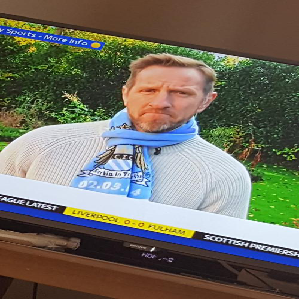

In [50]:
x, y = next(train_generator)

print(len(x))
print(x[0][0], x[0][0].shape)
print(x[1][0], x[1][0].shape)
print(x[2][0], x[2][0].shape)
im = x[2][0] * 255
im = Image.fromarray(np.uint8(im), 'RGB')
display(im)

In [39]:
list(train_y).index(0)
print(list(train_y)[:1200])
print(img_generator.classes[:1200])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 